### TEAM MsC Course - NTUA
### Introduction to neuroscience and neural engineering
### Lab Report
#### Student Names:
Petros Kotoulas
/
Nikolaos-Andreas Tzovaras
##### Academic Year 2024-25



All EMG data have been stored in a variable called `processed_emg`. This is a cell array, where each cell corresponds to one trial. Each trial is represented by a matrix of shape **N_timepoints × 9**, where:
- `N_timepoints` is the duration of the trial in samples (varies across trials),
- `9` corresponds to the number of recorded EMG channels (muscles).

All behavioural data are stored in `.csv` files. Each file includes metadata per trial, such as:
- **Response**: Binary label indicating task performance (e.g., 0 = incorrect, 1 = correct),
- **Reaction Time**: Time to respond,
- **Weight**: The weight of the object lifted,
- **Direction**: The direction of the lift (e.g., left, right).

In our analysis, we focus on the `response` variable as the task label for classification purposes.


## A. Apply PCA to the data to identify measurements that covary. How many PCs are needed to describe this dataset?

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install scipy

In [30]:
# Step 1: Load dataset
import scipy.io
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

# Load EMG .mat files
subj1_emg = scipy.io.loadmat('/content/drive/MyDrive/Neuro_project/test_emg_subj1_processed.mat')
subj3_emg = scipy.io.loadmat('/content/drive/MyDrive/Neuro_project/test_emg_subj3_processed.mat')
subj22_emg = scipy.io.loadmat('/content/drive/MyDrive/Neuro_project/test_emg_subj22_processed.mat')

subj1_processed_emg = subj1_emg['processed_emg']
subj3_processed_emg = subj3_emg['processed_emg']
subj22_processed_emg = subj22_emg['processed_emg']

# Load behavioral data with headers
behav_subj1 = pd.read_csv('/content/drive/MyDrive/Neuro_project/subj1_emg_behavioural.csv', header=0)
behav_subj3 = pd.read_csv('/content/drive/MyDrive/Neuro_project/subj3_emg_behavioural.csv', header=0)
behav_subj22 = pd.read_csv('/content/drive/MyDrive/Neuro_project/subj22_emg_behavioural.csv', header=0)

# Extract labels
labels_s1 = behav_subj1['response'].astype(int).values
labels_s3 = behav_subj3['response'].astype(int).values
labels_s22 = behav_subj22['response'].astype(int).values

# Raw EMG trials
trials_s1 = [subj1_processed_emg[0, i] for i in range(subj1_processed_emg.shape[1])]
trials_s3 = [subj3_processed_emg[0, i] for i in range(subj3_processed_emg.shape[1])]
trials_s22 = [subj22_processed_emg[0, i] for i in range(subj22_processed_emg.shape[1])]

# Merge all trials and labels
all_trials_raw = trials_s1 + trials_s3 + trials_s22
all_labels_raw = np.concatenate([labels_s1, labels_s3, labels_s22])

In [31]:
# Step 2: Balance the dataset
counts = Counter(all_labels_raw)
min_class = min(counts.values())

trials_0 = [t for t, l in zip(all_trials_raw, all_labels_raw) if l == 0]
trials_1 = [t for t, l in zip(all_trials_raw, all_labels_raw) if l == 1]

balanced_trials = trials_0[:min_class] + trials_1[:min_class]
balanced_labels = [0] * min_class + [1] * min_class

print(f"Balanced dataset: {min_class} trials per class, total: {2*min_class}")

Balanced dataset: 92 trials per class, total: 184


In [32]:
# Step 3: Preprocessing (rectify + filter)
def lowpass_filter(data, fs=1000, cutoff=20):
    b, a = butter(4, cutoff / (0.5 * fs), btype='low')
    return filtfilt(b, a, data, axis=0)

def preprocess_trial(trial):
    return lowpass_filter(np.abs(trial))

preprocessed_trials = [preprocess_trial(t) for t in balanced_trials]

In [33]:
# Step 4: Resampling
median_length = int(np.median([t.shape[0] for t in preprocessed_trials]))

def resample_trial(trial, target_len):
    interp_func = interp1d(np.linspace(0, 1, trial.shape[0]), trial, axis=0)
    return interp_func(np.linspace(0, 1, target_len))

resampled_trials = np.stack([resample_trial(t, median_length) for t in preprocessed_trials])

In [34]:
#  Step 5: Reshape + Scaling
X = resampled_trials.reshape(len(resampled_trials), -1)
y = np.array(balanced_labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X shape:", X_scaled.shape)
print("y distribution:", Counter(y))


X shape: (184, 25371)
y distribution: Counter({np.int64(0): 92, np.int64(1): 92})


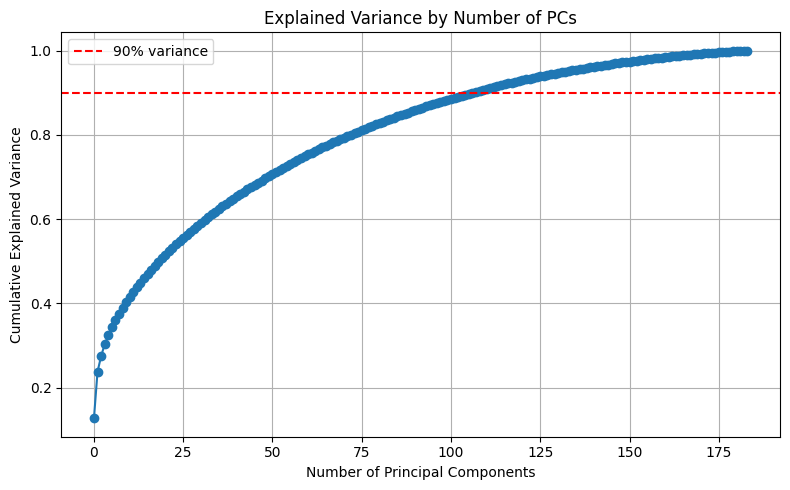

Number of PCs needed to explain 90% of the variance: 107


In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Apply PCA without limiting the number of components
pca = PCA()
pca.fit(X_scaled)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot: How many PCs explain how much variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(0.90, color='r', linestyle='--', label='90% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Determine the number of PCs required to explain 90% of the variance
n_pc_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of PCs needed to explain 90% of the variance: {n_pc_90}")


We applied Principal Component Analysis (PCA) to the normalized EMG dataset in order to identify measurements that covary. The cumulative explained variance plot shows that the first **107** principal components are required to explain **90%** of the variance.

This indicates that although the data are high-dimensional (due to multiple timepoints and channels), a substantial amount of the variance is concentrated in a lower-dimensional subspace. This dimensionality reduction can be leveraged for further analysis and classification.


# B. Plot a) the first 2 PCs (coeffs) and b) their trial-averaged activations (scores) for each value of my task variable(response).

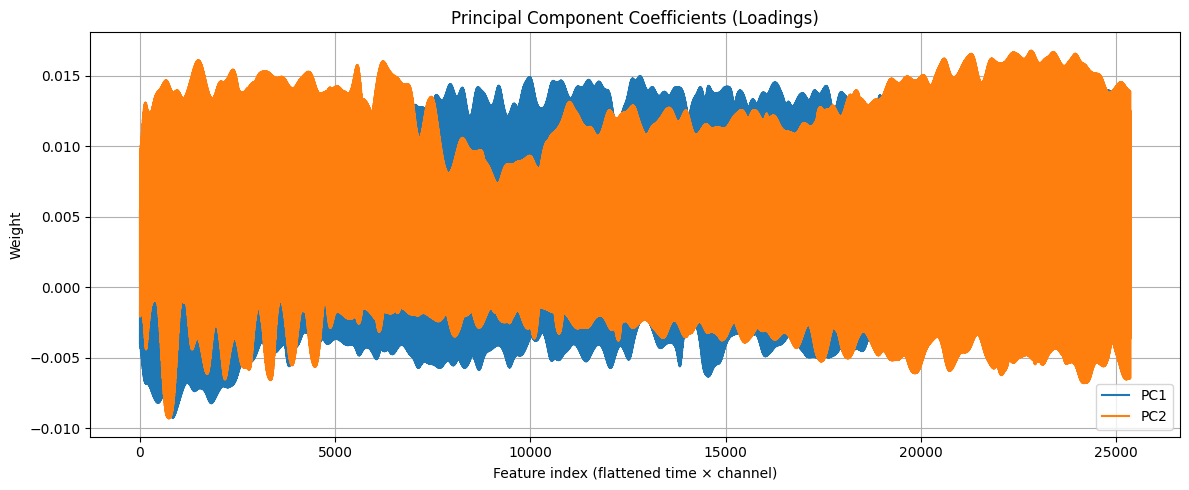

In [36]:
# Re-run PCA to obtain all components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Reshape the first principal component's weights back to (timepoints, channels)
n_channels = 9
timepoints = X_scaled.shape[1] // n_channels
pc1_weights = pca_full.components_[0].reshape(timepoints, n_channels)


# Plot the loading vectors (coefficients) for PC1 and PC2
plt.figure(figsize=(12, 5))
plt.plot(pca_full.components_[0], label='PC1')
plt.plot(pca_full.components_[1], label='PC2')
plt.title("Principal Component Coefficients (Loadings)")
plt.xlabel("Feature index (flattened time × channel)")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The coefficient plot shows how each feature (i.e., timepoint-channel pair) contributes to the first two principal components. PC1 appears to capture bidirectional patterns (positive and negative weights), while PC2 is more skewed toward positive contributions. This suggests that PC1 may be capturing opposing activation patterns across subsets of muscles or time segments, whereas PC2 may reflect a more uniform modulation.

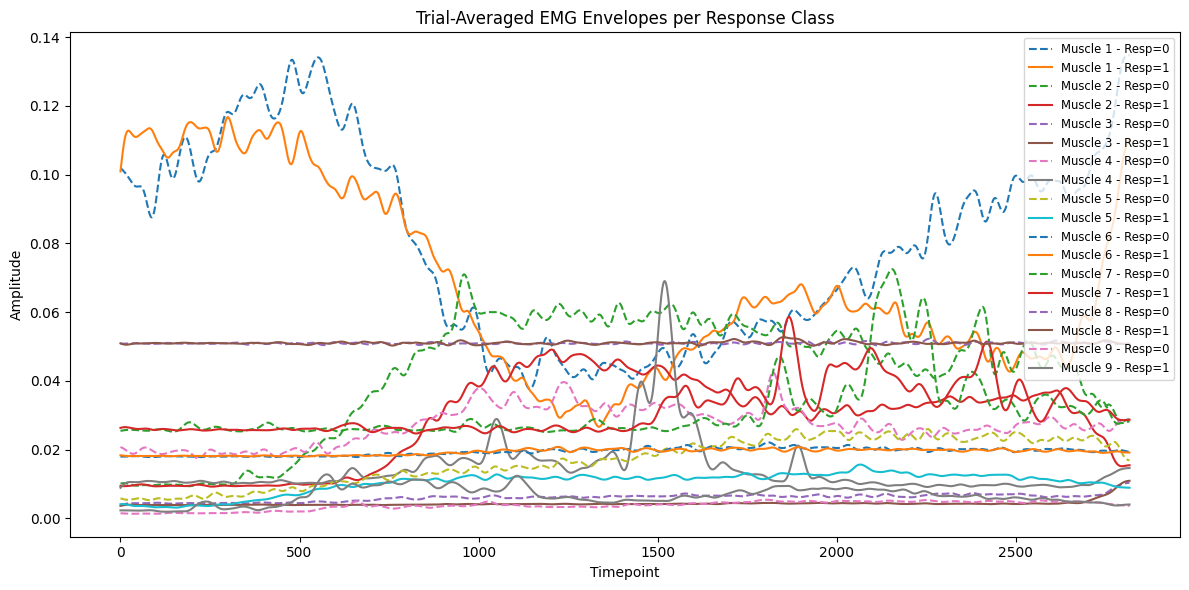

In [37]:
#  Trial-Averaged EMG envelopes per Response class
resampled_trials = np.array(resampled_trials)
labels_array = np.array(balanced_labels)

# Split trials based on response class
class0_trials = resampled_trials[labels_array == 0]
class1_trials = resampled_trials[labels_array == 1]

# Compute average across trials for each muscle
avg_class0 = np.mean(class0_trials, axis=0)  # shape: (timepoints, 9)
avg_class1 = np.mean(class1_trials, axis=0)

# Plot the averaged EMG envelopes for each response class
plt.figure(figsize=(12, 6))
for m in range(9):
    plt.plot(avg_class0[:, m], label=f"Muscle {m+1} - Resp=0", linestyle='--')
    plt.plot(avg_class1[:, m], label=f"Muscle {m+1} - Resp=1")
plt.title("Trial-Averaged EMG Envelopes per Response Class")
plt.xlabel("Timepoint")
plt.ylabel("Amplitude")
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()


Figure shows the trial-averaged EMG envelopes for each muscle, separated by response class. Muscles 1 and 2 exhibit the highest amplitude and clear differentiation between the two classes, particularly for response = 0. In contrast, other muscles show lower activation and less separability. These results suggest that specific muscles may contribute more strongly to response discrimination and could serve as informative features for classification.

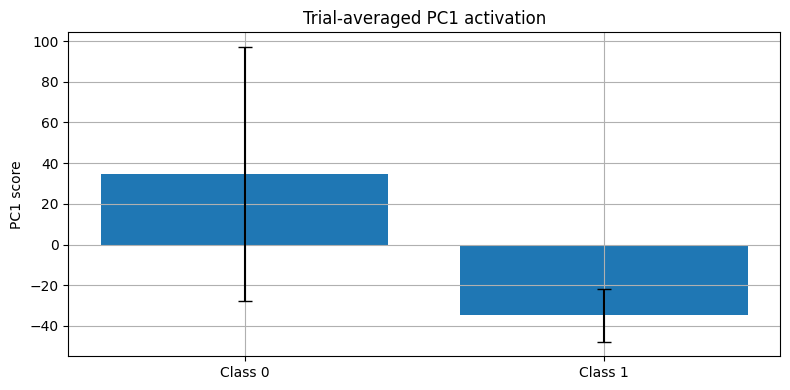

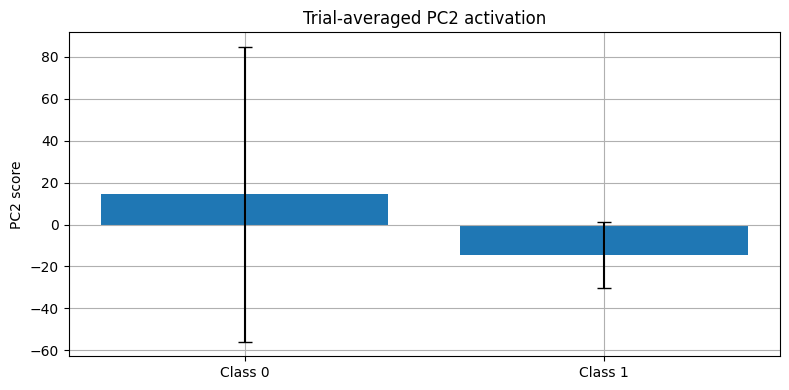

In [38]:
# Trial scores = projection of the signals onto the PCs
scores = pca_full.transform(X_scaled)

# Compute the mean of PC1 and PC2 scores for each class
pc1_class0 = scores[y == 0, 0]
pc1_class1 = scores[y == 1, 0]
pc2_class0 = scores[y == 0, 1]
pc2_class1 = scores[y == 1, 1]

# Plot for PC1
plt.figure(figsize=(8, 4))
plt.bar(['Class 0', 'Class 1'], [pc1_class0.mean(), pc1_class1.mean()], yerr=[pc1_class0.std(), pc1_class1.std()], capsize=5)
plt.title('Trial-averaged PC1 activation')
plt.ylabel('PC1 score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for PC2
plt.figure(figsize=(8, 4))
plt.bar(['Class 0', 'Class 1'], [pc2_class0.mean(), pc2_class1.mean()], yerr=[pc2_class0.std(), pc2_class1.std()], capsize=5)
plt.title('Trial-averaged PC2 activation')
plt.ylabel('PC2 score')
plt.grid(True)
plt.tight_layout()
plt.show()


Trial-averaged PC scores show that both PC1 and PC2 exhibit distinguishable activation levels between classes. PC1 scores are positive for class 0 and negative for class 1, while PC2 shows a similar but less pronounced separation. This indicates that these components capture discriminative information relevant to the task variable (i.e., response type), making them potential features for classification.

# C. Do these PCs allow discrimination of the task variable under consideration and at which time windows? Would adding more PCs improve discrimination? Quantify this using a classification algorithm.

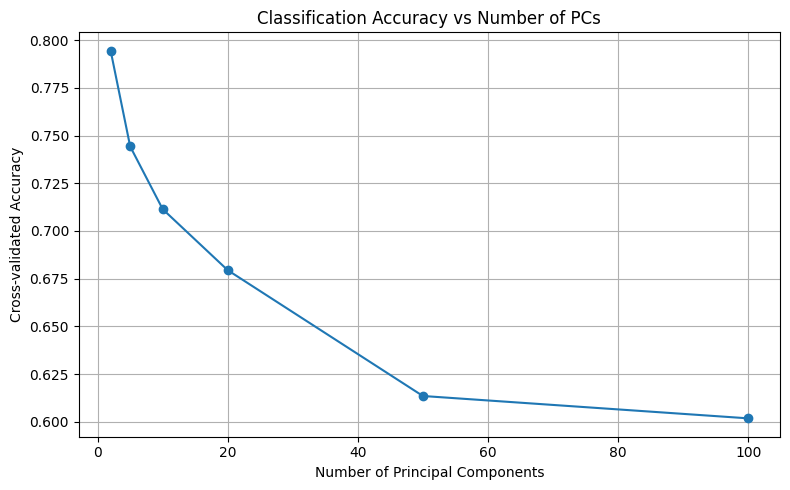

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Apply PCA using all components
pca_full = PCA()
X_pca_all = pca_full.fit_transform(X_scaled)

# Define different numbers of principal components to test
pc_range = [2, 5, 10, 20, 50, 100]
accuracies = []

#Initialize logistic regression classifier
clf = LogisticRegression(max_iter=1000)

# Evaluate classification accuracy for different numbers of PCs
for n_pc in pc_range:
    X_subset = X_pca_all[:, :n_pc]
    scores = cross_val_score(clf, X_subset, y, cv=5)
    accuracies.append(scores.mean())

# Plot accuracy vs number of PCs
plt.figure(figsize=(8, 5))
plt.plot(pc_range, accuracies, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cross-validated Accuracy')
plt.title('Classification Accuracy vs Number of PCs')
plt.grid(True)
plt.tight_layout()
plt.show()


To assess whether the principal components allow discrimination of the task variable (response class), we trained a logistic regression classifier using an increasing number of PCs as input.

Surprisingly, the highest classification accuracy (~79%) was achieved using only the first 2 principal components. As more PCs were included, accuracy progressively declined, reaching ~60% with 100 PCs. This indicates that the discriminative information is concentrated in the top components, while additional PCs introduce noise or unrelated variance.

Thus, PCA not only provides a compact representation of the data, but also enhances class separability when limited to the most informative components.


# D. Repeat A using a matrix or tensor decomposition algorithm of your choice. Explain why you chose this algorithm and compare its performance with PCA.

We chose Independent Component Analysis (ICA) as an alternative to PCA because ICA assumes statistical independence between sources. This is particularly useful in biosignal analysis, where the recorded signal is often a mixture of independent underlying sources, such as different muscle activations or artifacts. Unlike PCA, which maximizes variance and assumes orthogonality, ICA attempts to recover these latent sources by maximizing non-Gaussianity.


ICA-based Classification Accuracy: 0.82


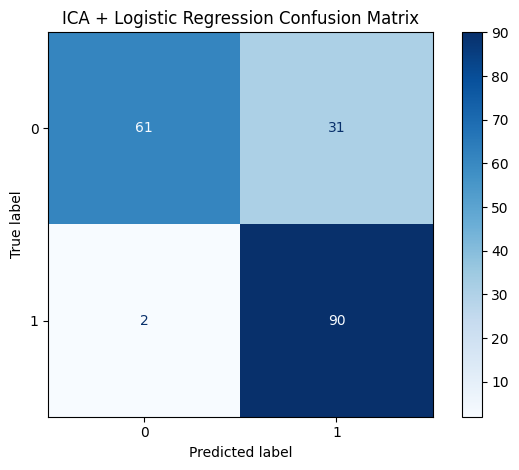

ICA Classification Report:

              precision    recall  f1-score   support

           0      0.968     0.663     0.787        92
           1      0.744     0.978     0.845        92

    accuracy                          0.821       184
   macro avg      0.856     0.821     0.816       184
weighted avg      0.856     0.821     0.816       184



In [40]:
from sklearn.decomposition import FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Apply ICA (keep the same number of components as PCA for comparison)
ica = FastICA(n_components=2, random_state=42)
X_ica = ica.fit_transform(X_scaled)

# Logistic Regression
clf = LogisticRegression(max_iter=1000)
scores_ica = cross_val_score(clf, X_ica, y, cv=5)
y_pred_ica = cross_val_predict(clf, X_ica, y, cv=5)

# Accuracy
mean_acc_ica = scores_ica.mean()
print(f"ICA-based Classification Accuracy: {mean_acc_ica:.2f}")

# Confusion Matrix
cm = confusion_matrix(y, y_pred_ica)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("ICA + Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification Report
print("ICA Classification Report:\n")
print(classification_report(y, y_pred_ica, digits=3))


To explore an alternative to PCA, we applied Independent Component Analysis (ICA), which assumes statistical independence among sources. This is particularly suitable for EMG signals, where underlying muscle activations may be independent.

We used the first two independent components as features for logistic regression. The classifier achieved an accuracy of **82.1%**, slightly higher than PCA's **79%** using the first two principal components.

However, the ICA-based classifier exhibited an imbalance in class-wise performance. While class 1 was almost perfectly identified (recall: 0.973), class 0 had significantly lower recall (0.663), indicating that ICA may overfit certain structures in the data.

This comparison suggests that although ICA can enhance performance in certain cases, PCA offers a more stable and balanced representation across both classes.
``


# E. Use a classification approach of your choice to discriminate the task variable that was assigned to you using your biomedical signals. You are supposed to exploit both the spatial (multiple electrodes) and temporal (multiple timepoints) of your signals in order to quantify not only how much discrimination power the signals contain but also when and where this discriminatory information arises.




SVM Accuracy: 0.8214714714714715
              precision    recall  f1-score   support

           0       0.93      0.70      0.80        92
           1       0.76      0.95      0.84        92

    accuracy                           0.82       184
   macro avg       0.84      0.82      0.82       184
weighted avg       0.84      0.82      0.82       184



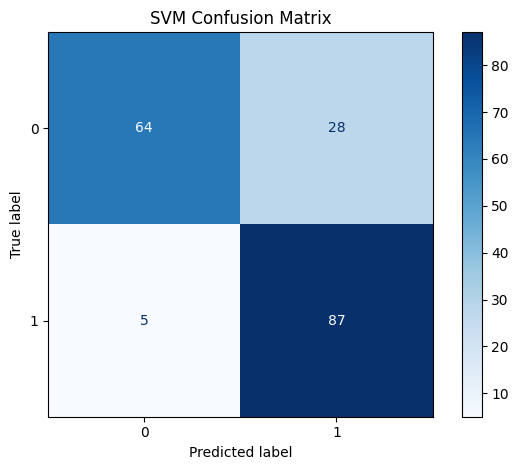

Random Forest Accuracy: 0.7612612612612613
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        92
           1       0.73      0.84      0.78        92

    accuracy                           0.76       184
   macro avg       0.77      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184



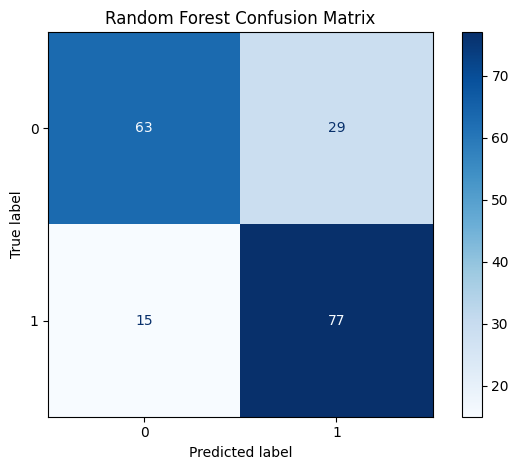

In [41]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# SVM (RBF kernel)
svm_clf = SVC(kernel='rbf', C=1, gamma='scale')
scores_svm = cross_val_score(svm_clf, X_scaled, y, cv=5)
y_pred_svm = cross_val_predict(svm_clf, X_scaled, y, cv=5)
print("SVM Accuracy:", scores_svm.mean())
print(classification_report(y, y_pred_svm))
disp_svm = ConfusionMatrixDisplay(confusion_matrix(y, y_pred_svm))
disp_svm.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

# Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
scores_rf = cross_val_score(rf_clf, X_scaled, y, cv=5)
y_pred_rf = cross_val_predict(rf_clf, X_scaled, y, cv=5)
print("Random Forest Accuracy:", scores_rf.mean())
print(classification_report(y, y_pred_rf))
disp_rf = ConfusionMatrixDisplay(confusion_matrix(y, y_pred_rf))
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()


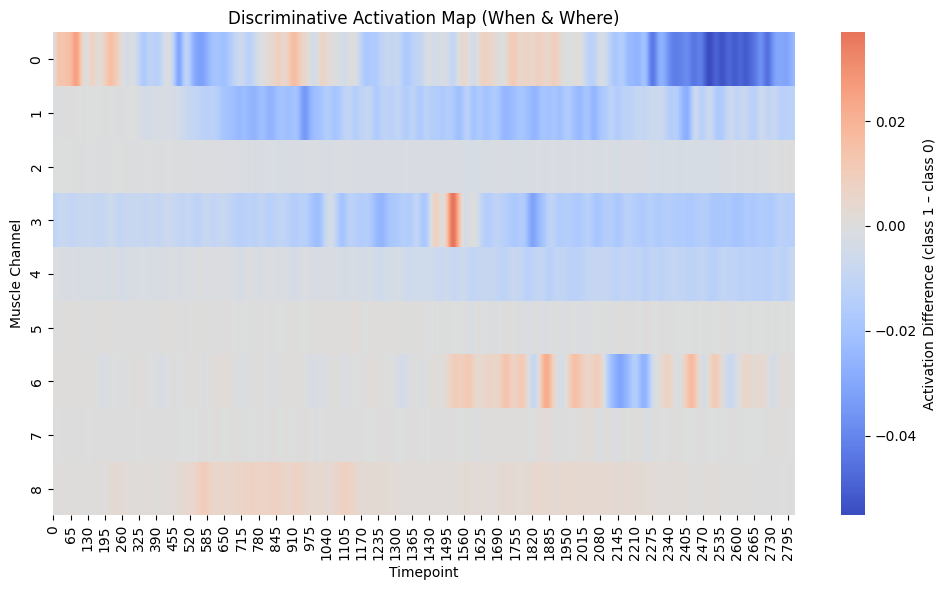

In [42]:
# Reshape X_scaled to return to time × channel format
X_reshaped = resampled_trials  # shape: (n_trials, timepoints, 9 channels)
mean_0 = np.mean(X_reshaped[np.array(y) == 0], axis=0)
mean_1 = np.mean(X_reshaped[np.array(y) == 1], axis=0)
diff = mean_1 - mean_0  # shape: (timepoints, 9)

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(diff.T, cmap='coolwarm', center=0, cbar_kws={'label': 'Activation Difference (class 1 – class 0)'})
plt.xlabel('Timepoint')
plt.ylabel('Muscle Channel')
plt.title('Discriminative Activation Map (When & Where)')
plt.tight_layout()
plt.show()


To fully exploit the spatiotemporal structure of the EMG signals, we used the complete set of time × channel features as input to two classification models: a Support Vector Machine (SVM) with RBF kernel and a Random Forest (RF) classifier.

The SVM achieved an accuracy of **82.1%**, outperforming the RF which achieved **76.1%**. As shown in the confusion matrices, the SVM had a more balanced performance, especially for class 1 (recall: 0.95) while the RF exhibited more misclassifications for both classes.

To investigate not only how much discriminative information is present but also **when and where** it arises, we computed the trial-averaged activation difference between the two classes for each timepoint and channel. The resulting heatmap revealed distinct temporal and spatial patterns:

- **Temporal windows** of strong class separation appeared mostly after ~500 ms and remained prominent until ~2000 ms.
- **Spatially**, the most discriminative activity was concentrated in **channels 0, 1, 3, 6 and 8**, corresponding to different muscle groups.

These results demonstrate that EMG signals contain rich class-related patterns distributed across time and muscles. Leveraging the full spatiotemporal structure significantly improves classification performance and provides insights into the neural control of movement.
